PICKING CARGO AT: Madiun. CURRENT PAYLOAD IS: 15
DROPPING CARGO AT: Nganjuk. CURRENT PAYLOAD IS: 0
PICKING CARGO AT: Nganjuk. CURRENT PAYLOAD IS: 19
DROPPING CARGO AT: Jombang. CURRENT PAYLOAD IS: 0
PICKING CARGO AT: Jombang. CURRENT PAYLOAD IS: 19
DROPPING CARGO AT: Mojokerto. CURRENT PAYLOAD IS: 0
PICKING CARGO AT: Mojokerto. CURRENT PAYLOAD IS: 15
DROPPING CARGO AT: Sidoarjo. CURRENT PAYLOAD IS: 0

[{'REWARD': 675000, 'BEBAN': 15, 'JENIS': 'PADAT', 'INITIAL': 'Madiun', 'GOAL': 'Nganjuk', 'PRECIOUSNESS': 22500, 'DONE': True}, {'REWARD': 640000, 'BEBAN': 19, 'JENIS': 'GAS', 'INITIAL': 'Nganjuk', 'GOAL': 'Jombang', 'PRECIOUSNESS': 16842, 'DONE': True}, {'REWARD': 615000, 'BEBAN': 19, 'JENIS': 'CAIR', 'INITIAL': 'Jombang', 'GOAL': 'Mojokerto', 'PRECIOUSNESS': 16184, 'DONE': True}, {'REWARD': 617500, 'BEBAN': 15, 'JENIS': 'PADAT', 'INITIAL': 'Mojokerto', 'GOAL': 'Sidoarjo', 'PRECIOUSNESS': 20583, 'DONE': True}]


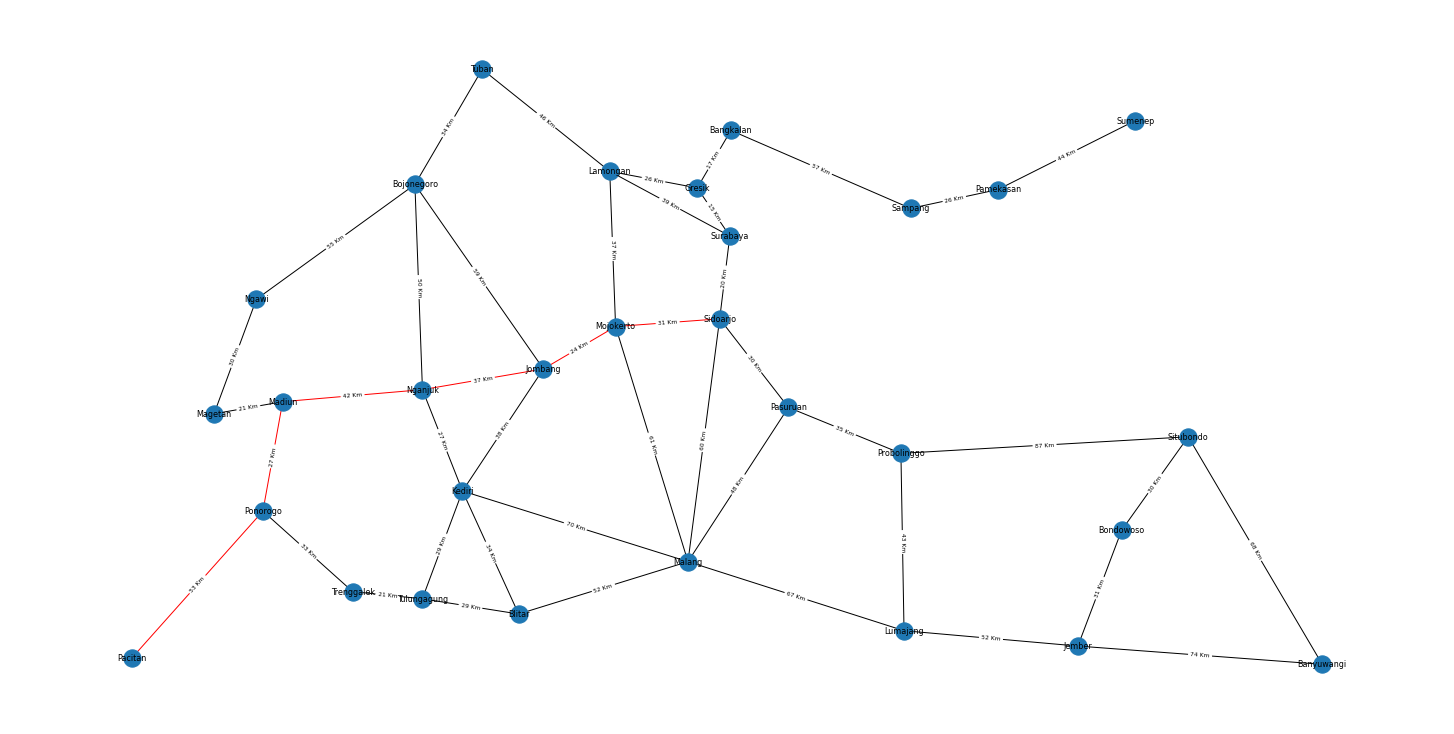

In [8]:
from tkinter import * 
from tkinter import messagebox
from PIL import ImageTk,Image

##########################BACKEND##################################
# IMPORTING NECESSARY LIBRARIES
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import math



# SETTING UP GRAPH SIZE
plt.figure(figsize=(20,10))




# CONSTANTS DECLARATION
CONST_KM_PER_LITRE = 20
CONST_KM_PER_DEG = 110.500




# DATA PREPARATION
df_coor = pd.read_csv('./dataset/dataset_lat-long_jatim-processed.csv') # dataset for positions and coordinates
df_jobs = pd.read_csv('./dataset/Dataset-barang-angkut-processed.csv') # dataset for job list
df_edgelist = pd.read_csv('./dataset/edgelist.csv')





# DATA PROCESSING
# GENERATING SEMI-ACCURATE ROAD MAPPING FOR THE GRAPH
def generate_edge_list(df):
    edges = []
    
    for i in range(len(df)):
        edges.append((df['source'][i], df['target'][i]))
    return edges

# COMPUTING EUCLIDIAN DISTANCE BETWEEN TWO COORDINATES POINTS 
def compute_euclidian_distance(A, B):
    x1 = A[0] 
    x2 = B[0] 
    y1 = A[1]
    y2 = B[1]

    distance = math.sqrt((abs(x1 - x2) ** 2) + (abs(y1 - y2) ** 2))
    return distance

# CONVERTING LAT-LNG TO KM FOR FUEL CONSIDERATION
def convert_latlong_to_km(value):
    return math.floor(value * CONST_KM_PER_DEG)

# GENERATING NODES POSITION FOR ACCURATE MAPPING OF EAST JAVA 
def generate_nodes_position(df):
    pos = {}
    
    for i in range(len(df)):
        pos[df['Daerah'][i]] = (df['Longitude'][i], df['Latitude'][i])

    return pos





# GRAPH PROCESSING
# ADDING WEIGHT TO THE GRAPH FOR SHORTEST_PATH CONSIDERATION
def assign_edge_weight(G, positions):
    for edge in G.edges:
        euc_distance = compute_euclidian_distance(positions[edge[0]], positions[edge[1]])
        converted_distance = convert_latlong_to_km(euc_distance)
        G[edge[0]][edge[1]]['distance'] = converted_distance

# GENERATING EDGE LABEL FOR BETTER VISUAL: REQUIRES EDGE WEIGHT TO BE ASSIGNED FIRST
def generate_edge_label(G):
    distance_label = {}

    for edge in G.edges:
        distance_label[edge] = str(G[edge[0]][edge[1]]['distance']) + ' Km' 
    
    return distance_label

# GENERATING COLORMAP FOR BETTER VISUAL
def generate_colormap(G, path, color):

    for edge in G.edges:
        G[edge[0]][edge[1]]['color'] = 'black'

    for i in range(len(path) - 1):
        G[path[i]][path[i + 1]]['color'] = color

    colormap = nx.get_edge_attributes(G, 'color').values()
    return colormap

# COMPUTING THE MINIMUM SOLAR REQUIRED FOR A GIVEN INITIAL AND GOAL : EDGE WEIGHT HAVE TO BE ASSIGNED FIRST
def compute_solar_required(G, initial, goal, ingfo=False):
    shortest_path = nx.shortest_path(G, source = initial, target =  goal, weight='distance')
    total_distance = 0

    for i in range(len(shortest_path) - 1):
        total_distance += G[shortest_path[i]][shortest_path[i + 1]]['distance']
    
    solar_required = math.ceil(total_distance / CONST_KM_PER_LITRE)
    if(ingfo):
        print("TOTAL DISTANCE FROM " + initial + " TO " + goal + " IS: " + str(total_distance) + 'KM')
        print("SOLAR REQUIRED FROM " + initial + " TO " + goal + " IS: " + str(solar_required) + 'L')

    return solar_required


# COMPUTING TOTAL DISTANCE : EDGE WEIGHT HAVE TO BE ASSIGNED FIRST
def compute_total_distance(G, initial, goal):
    shortest_path = nx.shortest_path(G, source = initial, target =  goal, weight='distance')
    total_distance = 0

    for i in range(len(shortest_path) - 1):
        total_distance += G[shortest_path[i]][shortest_path[i + 1]]['distance']
    return total_distance

# UTILITY FUNCTION FOR SORTING BY
def sort_by_preciousness(obj):
        return obj['PRECIOUSNESS']

# GENERATING JOBS DICT FOR REWARD EVALUATION AND PROCESSING DATA FOR JOBS
def generate_jobs(G, df):
    jobs = {}

    for node in G.nodes:
        jobs[node] = []

    for i in range(len(df)):
        jobs[df['INITIAL'][i]].append({'REWARD':df['REWARD'][i],'BEBAN':df['BEBAN MUATAN (TON)'][i],'JENIS':df['JENIS'][i],'INITIAL':df['INITIAL'][i], 'GOAL':df['GOAL'][i]})
        
    for node in G.nodes:
        for i in range(len(jobs[node])):
            if (jobs[node][i]['JENIS'] == 'CAIR') or (jobs[node][i]['JENIS'] == 'GAS'):
                jobs[node][i]['BEBAN'] += 4
            jobs[node][i]['PRECIOUSNESS'] = math.floor(jobs[node][i]['REWARD'] / jobs[node][i]["BEBAN"])
        jobs[node].sort(key=sort_by_preciousness, reverse=True)

    return jobs

# UTILITY FUNCTION FOR GETTING INDEX OF 
def indexOf(lst, val):
    for i in range(len(lst)):
        if val == lst[i]:
            return i
    return -1

# FILTERING THE JOBS THAT ARE 'SEARAH'
def generate_suitable_jobs(G, jobs, initial, goal):
    shortest_path = nx.shortest_path(G, initial, goal, weight='distance')
    matchInitialJobs = []
    for path in shortest_path:
        matchInitialJobs.append(jobs[path])

    matchInitialJobs = matchInitialJobs[0]
    matchInitialAndGoalJobs = []
    for job in matchInitialJobs:
        if indexOf(shortest_path,job['GOAL']) > indexOf(shortest_path,job['INITIAL']):
            matchInitialAndGoalJobs.append(job)
    
    ## FURTHER PROCESSING OF PRECIOUSNESS VALUE
    for job in matchInitialAndGoalJobs:
        citiesPassed = len(nx.shortest_path(G, job['INITIAL'], job['GOAL'], weight='distance'))
        job['PRECIOUSNESS'] = math.floor(job['PRECIOUSNESS'] / citiesPassed)

    matchInitialAndGoalJobs.sort(key=sort_by_preciousness, reverse=True)
    return matchInitialAndGoalJobs

# GENERATING THE MOST PAID JOB SEQUENCE
def generate_job_sequence(G, raw_jobs, initial, goal, max_ton):
    shortest_path = nx.shortest_path(G, initial, goal, weight='distance')

    payload_carried = 0
    jobs_taken = []
    current_taken_jobs = []
    job_sequence = ''
    for path in shortest_path:
        jobs = generate_suitable_jobs(G, raw_jobs, path, shortest_path[len(shortest_path) - 1])
        current_path = path
        current_region_jobs = []    

        for i in range(len(current_taken_jobs)):
            if (i >= len(current_taken_jobs)):
                break
            job = current_taken_jobs[i]
            if job['GOAL'] == current_path:
                payload_carried -= job['BEBAN']
                job_sequence += ('DROPPING CARGO AT: ' + current_path + '. CURRENT PAYLOAD IS: ' + str(payload_carried) + '\n')
                current_taken_jobs[i]['DONE'] = True
        
        for i in range(len(current_taken_jobs) - 1, -1, -1):
            if 'DONE' in current_taken_jobs[i]:
                del current_taken_jobs[i]

        for job in jobs:
            if(job['INITIAL'] == current_path):
                current_region_jobs.append(job)
            
        for job in current_region_jobs:
            if payload_carried < max_ton:
                if (job['BEBAN'] + payload_carried) < max_ton:
                    payload_carried += job['BEBAN']
                    job_sequence += ('PICKING CARGO AT: ' + current_path + '. CURRENT PAYLOAD IS: ' + str(payload_carried) + '\n')
                    jobs_taken.append(job)
                    current_taken_jobs.append(job)
                    

    return (jobs_taken, job_sequence)
        
# COMPUTING TOTAL REWARD FROM JOB SEQUENCE THAT HAS BEEN TAKEN
def compute_total_reward(jobs_taken):
    total_reward = 0

    for job in jobs_taken:
        total_reward += job['REWARD']

    return total_reward


# PROGRAM'S FLOW
# USER INPUT


# GRAPH INITIALIZATION
G = nx.Graph()
edges = generate_edge_list(df_edgelist)
pos = generate_nodes_position(df_coor)


##########################BACKEND##################################


##########################TOOLS##################################
width = 1366
height = 768
def show_frame(frame,button):
    if button == "dashboard":
        dasboard.configure(bg="white")
        search_path.configure(bg="grey")
        visual.configure(bg="grey")
        job.configure(bg="grey")
    elif button == "search":
        dasboard.configure(bg="grey")
        search_path.configure(bg="white")
        visual.configure(bg="grey")
        job.configure(bg="grey")
    elif button == "visual":
        dasboard.configure(bg="grey")
        search_path.configure(bg="grey")
        visual.configure(bg="white")    
        job.configure(bg="grey")
    elif button == "job":
        dasboard.configure(bg="grey")
        search_path.configure(bg="grey")
        visual.configure(bg="grey")
        job.configure(bg="white")
    frame.tkraise()

def visual_frame():
    global startInitialEntry,endInitialEntry,fuelInitialEntry,tonInitialEntry,frame3,jobs,frameSecondChild,frameThirdChild,renderGraph1,root,G
    start = startInitialEntry.get()
    end = endInitialEntry.get()
    fuel = fuelInitialEntry.get()
    ton = tonInitialEntry.get()
    # ADDING PROPERTIES TO THE GRAPH: DISTANCE,COLOR, ETC.
    G.add_edges_from(edges)
    assign_edge_weight(G, positions=pos)
    edge_label = generate_edge_label(G)
    shortest_path = nx.shortest_path(G, start, end,weight="distance")
    colormap = generate_colormap(G, shortest_path, 'red')
    solar = compute_solar_required(G,start,end)
    distance = compute_total_distance(G,start,end)
    jobs = generate_jobs(G, df_jobs)
    job_data = (generate_job_sequence(G, jobs, start, end, int(ton)))
    jobs_taken = job_data[0]
    jobs_sequence = job_data[1]
    total_reward = compute_total_reward(jobs_taken)
    print(jobs_sequence)
    print(jobs_taken)

    # RENDERING THE GRAPH
    plt.clf()
    nx.draw(G, pos=pos, with_labels=True, font_size=8, edge_color=colormap)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_label, font_size=6)
    plt.savefig('./graph.png', dpi=500)
    if int(fuel) < solar:
        messagebox.showwarning("peringatan","bensin tidak cukup untuk pulang")
    else:
        graph = ImageTk.PhotoImage((Image.open("./graph.png")).resize((1106,570),Image.ANTIALIAS),master=frame3)
        renderGraph1.configure(image=graph)
        renderGraph1.image = graph
        firstInfo = Label(frameSecondChild,text="TOTAL DISTANCE FROM {start} TO {end} IS: {distance}KM".format(start=start,end=end,distance=distance),bg="grey",fg="white",font=("times",15,"bold"),relief=RIDGE,bd=0)
        firstInfo.place(x=0,y=20,width=520,height=20)
        secondInfo = Label(frameSecondChild,text="SOLAR REQUIRED FROM {start} TO {end} IS: {solar}L".format(start=start,end=end,solar=solar),bg="grey",fg="white",font=("times",15,"bold"),relief=RIDGE,bd=0)
        secondInfo.place(x=0,y=40,width=500,height=20)
        thirdInfo = Label(frameSecondChild,text="MAX TON FROM {start} TO {end} IS: {ton}TON".format(start=start,end=end,ton=ton),bg="grey",fg="white",font=("times",15,"bold"),relief=RIDGE,bd=0)
        thirdInfo.place(x=0,y=60,width=440,height=20)
        fourthInfo = Label(frameSecondChild,text="TOTAL REWARD :  {reward}".format(reward=total_reward),bg="grey",fg="white",font=("times",15,"bold"),relief=RIDGE,bd=0)
        fourthInfo.place(x=0,y=80,width=270,height=20)
   
    seqeunce = Label(frameThirdChild,text=jobs_sequence,bg="grey",fg="white",font=("times",10,"bold"),relief=RIDGE,bd=0)
    seqeunce.place(x=30,y=0,width=1106,height=400)
      
    startInitialEntry.delete(0,END)
    endInitialEntry.delete(0,END)
    fuelInitialEntry.delete(0,END)
    tonInitialEntry.delete(0,END)
    root.update_idletasks()
##########################TOOLS##################################

root = Tk()
root.geometry("1366x768")
root.title("LKS SYSTEM 2022")
root.iconphoto(False,ImageTk.PhotoImage(Image.open("../Assets/Truk.png"),master=root))
title_label = Label(root,text="LKS SMK TELKOM MALANG",font=("times",50,"bold"),relief=RIDGE,bg = "red",fg="white",bd = 20)
title_label.pack(fill=X)
feature = Frame(root,bg="grey")
feature.place(x=0,y=118,width=200,height=640)
dasboard = Button(feature,text = "Dashboard",bg="white",fg="red",font=("times",20),relief=RIDGE,bd=0,command=lambda:show_frame(frame1,"dashboard"))
dasboard.place(x=0,y=80,width=200,height=50)
search_path = Button(feature,text = "Search",bg="grey",fg="red",font=("times",20),relief=RIDGE,bd=0,command=lambda:show_frame(frame2,"search"))
search_path.place(x=0,y=170,width=200,height=50)
visual = Button(feature,text = "Visual",bg="grey",fg="red",font=("times",20),relief=RIDGE,bd=0,command=lambda:show_frame(frame3,"visual"))
visual.place(x=0,y=350,width=200,height=50)
job = Button(feature,text = "List Job",bg="grey",fg="red",font=("times",20),relief=RIDGE,bd=0,command=lambda:show_frame(frame4,"job"))
job.place(x=0,y=260,width=200,height=50)
exit_apk = Button(feature,text = "Exit",bg="grey",fg="red",font=("times",20),relief=RIDGE,bd=0,command=lambda:root.destroy())
exit_apk.place(x=0,y=450,width=200,height=50)
label_telkom = Label(feature,text="@SMK Telkom Malang",bg="grey",fg="white",font=("times",10,"bold"),relief=RIDGE,bd=0)
label_telkom.place(x=0,y=550,width=200,height=50)
frame1 = Frame(root,bg="white")
frame1.place(x=200,y=118,width=1166,height=640)
frame2 = Frame(root,bg="white")
frame2.place(x=200,y=118,width=1166,height=640)
frame3 = Frame(root,bg="white")
frame3.place(x=200,y=118,width=1166,height=640)
frame4 = Frame(root,bg="white")
frame4.place(x=200,y=118,width=1166,height=640)

##########################frame1##################################
greeting = Label(frame1,text="Welcome to our system!",bg="white",fg="red",font=("helvetica",60,"bold"))
greeting.place(x=30,y=30,width=1136,height=120)
java = ImageTk.PhotoImage((Image.open("../Assets/java.png")).resize((1000,400),Image.ANTIALIAS),master=frame1)
peta = Label(frame1,image=java)
peta.place(x=30,y=150,width=1106,height=420)
##########################frame1##################################

##########################frame2##################################
frameChild = Frame(frame2,bg="grey",relief=RIDGE,bd=20)
frameChild.place(x=30,y=30,width=1106,height=570)
startInitial = Label(frameChild,text="Start Intial",font=("times",30,"bold"),bg="grey",fg="red")
startInitial.place(x=10,y=50,width=320,height=50)
startInitialEntry = Entry(frameChild,font=("times",20),bg="white",fg="red",relief=RIDGE,bd=0)
startInitialEntry.place(x=110,y=120,width=320,height=50)
endInitial = Label(frameChild,text="End Goal",font=("times",30,"bold"),bg="grey",fg="red")
endInitial.place(x=560,y=50,width=320,height=50)
endInitialEntry = Entry(frameChild,font=("times",20),bg="white",fg="red",relief=RIDGE,bd=0)
endInitialEntry.place(x=660,y=120,width=320,height=50)
fuelInitial = Label(frameChild,text="Set Fuel",font=("times",30,"bold"),bg="grey",fg="red")
fuelInitial.place(x=0,y=270,width=320,height=50)
fuelInitialEntry = Entry(frameChild,font=("times",20),bg="white",fg="red",relief=RIDGE,bd=0)
fuelInitialEntry.place(x=110,y=340,width=320,height=50)
tonInitial = Label(frameChild,text="Max Ton",font=("times",30,"bold"),bg="grey",fg="red")
tonInitial.place(x=560,y=270,width=320,height=50)
tonInitialEntry = Entry(frameChild,font=("times",20),bg="white",fg="red",relief=RIDGE,bd=0)
tonInitialEntry.place(x=660,y=340,width=320,height=50)
search_button = Button(frameChild,text="Execute",font=("times",20,"bold"),bg="green",fg="white",relief=RIDGE,bd=0,command=lambda:visual_frame())
search_button.place(x=700,y=420,width=320,height=70)
##########################frame2##################################

##########################frame3##################################
renderGraph1 = Label(frame3)
renderGraph1.place(x=30,y=30,width=1106,height=570)
##########################frame3##################################

##########################frame4##################################
frameSecondChild = Frame(frame4,bg="grey",relief=RIDGE,bd=0)
frameSecondChild.place(x=30,y=430,width=1106,height=150)
frameThirdChild = Frame(frame4,bg="grey")
frameThirdChild.place(x=30,y=20,width=1106,height=390)
##########################frame4##################################

show_frame(frame1,"dasboard")
root.mainloop()